In [1]:
import pandas as pd

# Set the directory path and filenames
dir_path = 'C:/1. Power grid frequency data/'
file_names = ['ES_PM01.csv', 'IS02.csv', 'IRL01.csv']

# Load the CSV files into dataframes
dfs = []
for file_name in file_names:
    file_path = dir_path + file_name
    df = pd.read_csv(file_path, sep=';', 
                     usecols=[0,1,2], names=['Time','f50','QI'],
                     header=0)
    dfs.append(df)


# Only select quality QI=0
flt_dfs = []
for df in dfs:
    flt_df = df[df['QI'] == 0]
    flt_dfs.append(flt_df)
    
region_dict = {0: 'Mallorcaa', 1: 'Iceland', 2: 'Ireland'}

# Group the dataframes by region
region_groups = [df.groupby(lambda x: region_dict[i]) for i, df in enumerate(flt_dfs)]

In [14]:
def CKtest (data, tau1, tau2, tau3, bins):
    
    data1 = data[tau1:-tau1] # x3
    data2 = data[tau2:-tau2] # x2
    data3 = data[tau3:-tau3] # x1
    
    # Find bin borders
    dx1 = np.ptp(data3/(bins-1))  # the difference between max and min of data
    dx2 = np.ptp(data2)/(bins-1)
    dx3 = np.ptp(data1)/(bins-1)
    x1 = np.arange(min(data3), np.max(data3)+dx1, dx1)
    x2 = np.arange(min(data2), np.max(data2)+dx2, dx2)
    x3 = np.arange(min(data1), np.max(data1)+dx3, dx3)
    dA = dx1 * dx2
    dV = dx1 * dx2 * dx3
    
    # Finding 2D conditional PDF P(Xt|X(t-1)) or P(x1|x2)
    X = np.column_stack((data3[:len(data3)], data2[:len(data3)]))
    count, edges = np.histogramdd(X, bins=[x1, x2])
    p_12_ref = count/(len(X)*dA)  # Joint PDF of x1, x2
    
    # Calculate p_2
    p_2 = np.zeros(bins-1) # 1d PDF P(x2)
    
    for j in range(bins-1):
        p_2[j] = np.sum(p_12_ref[j,:]) * dx1
        
        # Initialize p_1_2
        p_1_2 = np.zeros((bins-1, bins-1))
        
    # Calculate conditional PDF p_1_2
    for j in range(bins-1):
        if p_2[j] > 0:
            p_1_2[:,j] = p_12_ref[:,j] / p_2[j]

            
    # Set values less than 1e-3 to zero
    p_1_2[p_1_2 < 1e-3] = 0
    
    #Finding 3D conditional PDF P(X_t|X_(t-1),X_(t-2)) or P(x1|x2,x3)
    Y = np.zeros((len(data3), 3))
    Y[:, 0] = data3[:len(data3)]
    Y[:, 1] = data2[:len(data3)]
    Y[:, 2] = data1[:len(data3)]


    edges = (x1, x2, x3)
    count, edges = np.histogramdd(Y, bins=edges)
    mid = [0.5 * (edges[i][1:] + edges[i][:-1]) for i in range(3)]
    loc = np.array(np.unravel_index(np.arange(bins ** 3), (bins, bins, bins)), order='F').T

    # calculate the joint PDF of x2 and x3
    p_123_ref = count / (len(Y) * dV) # % Conditional PDF P(x1|x2,x3)
    p_23 = np.zeros((bins-1, bins-1))
    for i in range(bins-1):
        for j in range(bins-1):
            p_23[i, j] = np.sum(p_123_ref[i, j, :]) * dx1
            
    # calculate the conditional PDF of x1 given x2 and x3
    p_1_23 = np.zeros((bins-1, bins-1, bins-1))
    for i in range(bins-1):
        for j in range(bins-1):
            if p_23[i, j] > 0:
                p_1_23[:, i, j] = p_123_ref[:, i, j] / p_23[i, j]

    
    return x1, x2, p_1_2,p_1_23
    

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Define tau value sets
tau_sets = [
    [2, 4, 6],
    [5,10, 15],
    [20, 40, 60],
    [30, 60, 90],
    [50, 100, 150],
    [70, 140, 210],
    [90, 180, 270],
    [100, 200, 300],
    [200, 400, 600],
    [300, 600, 900],
    [400, 800, 1200],
    [500, 1000, 1500],
    [600, 1200, 1800],
    [700, 1400, 2100],
    [800, 1600, 2400],
    [900, 1800, 2700],
    [1000, 2000, 3000]
    
]

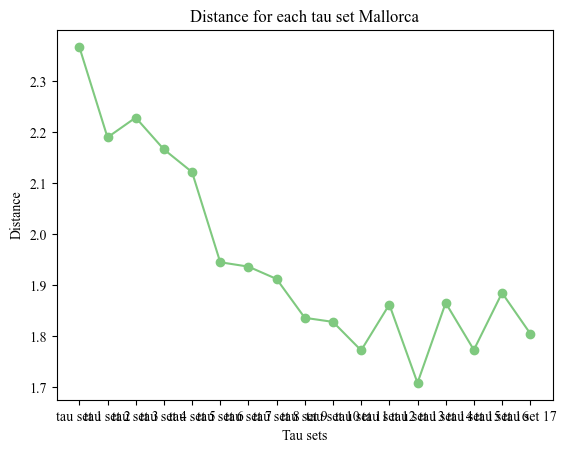

In [20]:
mal_distances=[]

# Iterate through tau value sets
for tau in tau_sets: 
    # Calculate CK test for dataframe
    x1, x2, p_1_2, p_1_23 = CKtest(flt_dfs[0].f50.dropna().values, tau[0], tau[1], tau[2], 51)
    
    # Normalize p_1_2 and p_1_23
    p_1_2_normalized = p_1_2 / np.sum(p_1_2)
    p_1_23_normalized = p_1_23 / np.sum(p_1_23)
    
    # Calculate distance 
    distance = -np.log(np.sum(np.sqrt(p_1_2_normalized* p_1_23_normalized[:, :, 25])))
    mal_distances.append(distance)

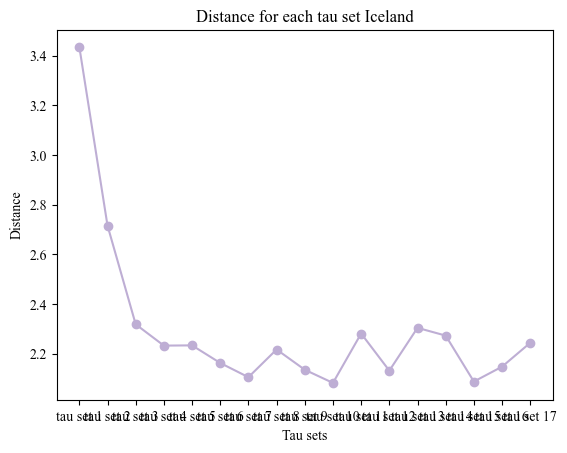

In [21]:
ice_distances=[]

# Iterate through tau value sets
for tau in tau_sets: 
    # Calculate CK test for dataframe
    x1, x2, p_1_2, p_1_23 = CKtest(flt_dfs[1].f50.dropna().values, tau[0], tau[1], tau[2], 51)
    
    # Normalize p_1_2 and p_1_23
    p_1_2_normalized = p_1_2 / np.sum(p_1_2)
    p_1_23_normalized = p_1_23 / np.sum(p_1_23)
    
    # Calculate distance 
    distance = -np.log(np.sum(np.sqrt(p_1_2_normalized* p_1_23_normalized[:, :, 25])))
    ice_distances.append(distance)

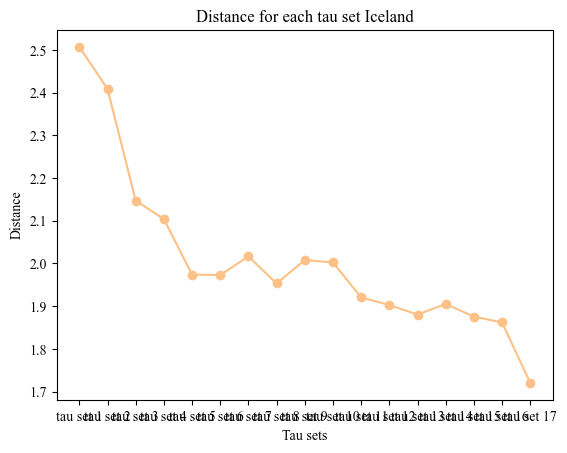

In [22]:
ire_distances=[]

# Iterate through tau value sets
for tau in tau_sets: 
    # Calculate CK test for dataframe
    x1, x2, p_1_2, p_1_23 = CKtest(flt_dfs[2].f50.dropna().values, tau[0], tau[1], tau[2], 51)
    
    # Normalize p_1_2 and p_1_23
    p_1_2_normalized = p_1_2 / np.sum(p_1_2)
    p_1_23_normalized = p_1_23 / np.sum(p_1_23)
    
    # Calculate distance 
    distance = -np.log(np.sum(np.sqrt(p_1_2_normalized* p_1_23_normalized[:, :, 25])))
    ire_distances.append(distance)

Stored 'euro_dis' (list)


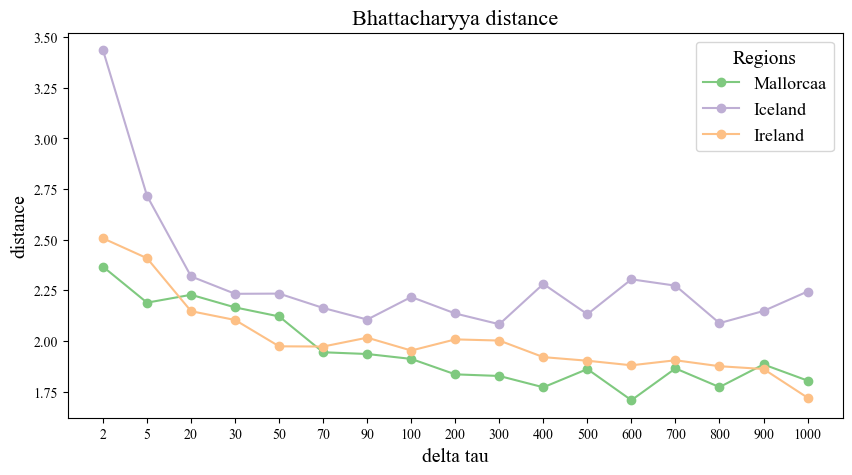

In [12]:
euro_dis=[mal_distances,ice_distances,ire_distances]
%store euro_dis

colors=('#7fc97f', '#beaed4','#fdc086')

fig, ax = plt.subplots(figsize=(10,5))

for i, df in enumerate(euro_dis):
    ax.plot(range(len(tau_sets)),df, 'o-',color=colors[i], label=region_dict[i])
    ax.set_title('Bhattacharyya distance',fontsize=16)
    ax.set_xlabel('delta tau',fontsize=14)
    ax.set_ylabel('distance',fontsize=14)

#ax.set_xticklabels([0,2,5,20,30,50,70,90,100], fontsize=12)
plt.xticks(range(len(tau_sets)),[2,5,20,30,50,70,90,100,200,300,400,500,600,700,800,900,1000]) 
plt.legend(title = "Regions", title_fontsize=14, fontsize=13, loc='upper right')

plt.show()

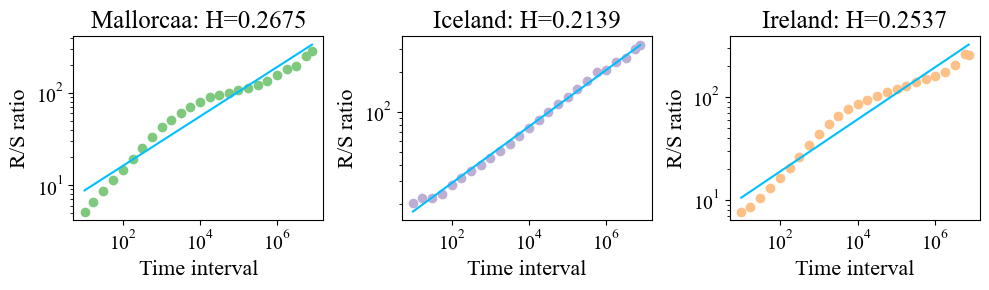

In [5]:
colors=('#7fc97f', '#beaed4','#fdc086')

import numpy as np
import matplotlib.pyplot as plt
from hurst import compute_Hc, random_walk
from fbm import FBM

# Evaluate Hurst equation and plot for each region
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
for i, ax in enumerate(axes.flat):
    H, c, data = compute_Hc(flt_dfs[i].f50.dropna().values/1000+50, kind='price', simplified=True)
    ax.plot(data[0], c*data[0]**H, color="deepskyblue")
    ax.scatter(data[0], data[1], color=colors[i])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Time interval', fontsize=16)
    ax.set_ylabel('R/S ratio', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    #ax.grid(True)
    #ax.set_title(region_dict[i] + '\nH={:.4f}'.format(H))  # add H value to subplot title
    ax.set_title('{}: H={:.4f}'.format(region_dict[i], H), fontsize=18) 
fig.tight_layout()

plt.rcParams.update({'font.family': 'Times New Roman'})
plt.show()